# 1997 Sao Paulo Measles Outbreak

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import trans
from datetime import datetime
import matplotlib.pyplot as plt
pd.set_option('max_columns', 20)
pd.set_option('max_rows', 25)

from pymc import (Bernoulli, Normal, Uniform, invlogit, deterministic, Lambda, MvNormalCov, HalfCauchy, 
 Gamma, Binomial, DiscreteUniform, MvNormal, Lambda, Exponential, MCMC, Matplot, NegativeBinomial,
 negative_binomial_like, observed, Poisson, Lognormal, stochastic, binomial_like, potential, negative_binomial_like)

from __future__ import division

In [3]:
measles_data = pd.read_csv("Sao Paulo/MATMEASLES1997.csv", encoding="ISO-8859-1")
measles_data.head()

,NUMBER,NOTIFICATION,BIRTH,AGE,TYPE,SEX,DISTRICT,COUNTY,MONTH,YEAR,WEEK,ONSET,CONCLUSION,BIRTH YEAR
0,25,1/8/97,1/7/73,24,Y,M,NaN,POA,1,97,1,1/2/97,CONFIRMED,73
1,23955,1/17/97,4/23/90,6,Y,M,NaN,TATUI,1,97,2,1/9/97,CONFIRMED,91
2,68,2/26/97,1/7/73,24,Y,F,NaN,GUARULHOS,1,97,2,1/10/97,CONFIRMED,73
3,33,1/27/97,1/7/76,21,Y,F,NaN,GUARULHOS,1,97,2,1/12/97,CONFIRMED,76
4,28,1/21/97,1/7/76,21,Y,F,NaN,POA,1,97,2,1/12/97,CONFIRMED,76


In [4]:
measles_data.NOTIFICATION = pd.to_datetime(measles_data.NOTIFICATION)
measles_data.BIRTH = pd.to_datetime(measles_data.BIRTH)
measles_data.ONSET = pd.to_datetime(measles_data.ONSET)

In [5]:
measles_data.columns = [name.strip() for name in measles_data.columns]
measles_data["BIRTH YEAR"] += 1900
measles_data["YEAR_AGE"] = 1997 - measles_data["BIRTH YEAR"]

In [6]:
measles_data.CONCLUSION.value_counts()

CONFIRMED                             23530
DISCARDED                             20514
CLINICAL                              18659
NO REAGENT AND IMPROPER COLLECTION     1843
dtype: int64

In [7]:
CONFIRMED = measles_data.CONCLUSION == 'CONFIRMED'
CLINICAL = measles_data.CONCLUSION == 'CLINICAL'
DISCARDED = measles_data.CONCLUSION == 'DISCARDED'

### Vaccination data

Routine coverage by year from 1976-1996.

Some sources of uncertainty here: these are national figures, and individual states within Brazil had some differences in vaccination policy.

SIA Vaccine Coverage:

- 1987 SIA targeted ages 9 months to 14 years, covering ages 10-24 by the time of outbreak. Post-campaign coverage was estimated at 86-90%. A serosurvey at the time saw 97% immunity in ages 1-14.
- 1992 SIA targeted ages 1-10 years, covering ages 6-15 by the time of outbreak. Estimated 96% post-campaign coverage. 98% of the 1-14 population was immune according to a serosurvey.

In [8]:
coverage = pd.read_csv("Sao Paulo/routinecoverage.csv", index_col=0) * 0.01
coverage

,% coverage
Year,
1976,0.28
1977,0.42
1978,0.43
1979,0.51
1980,0.57
1981,0.73
1982,0.66
1983,0.68
1984,0.73


### Population data

In [9]:
sp_pop = pd.read_csv("Sao Paulo/population/sao paulo-Table 1.csv", encoding='utf8', index_col=0)

In [10]:
import unicodedata

def strip_accents(text):
    # Deal with Latin characters
    return ''.join(c for c in unicodedata.normalize('NFKD', text) if unicodedata.category(c) != 'Mn')

# New index
uc_dist = [strip_accents(dist).upper() for dist in sp_pop.index]
sp_pop.index = uc_dist

sp_pop.head()

,0 a 4 anos,5 a 9 anos,10 a 14 anos,15 a 19 anos,20 a 24 anos,25 a 29 anos,30 a 34 anos,35 a 39 anos,40 a 44 anos,45 a 49 anos,50 a 54 anos,55 a 59 anos,60 a 64 anos,65 a 69 anos,70 a 74 anos,75 anos e +,Total
AGUA RASA,5411,5750,6450,7122,7621,7340,6999,6984,6346,5608,4987,4212,4152,3595,2937,3637,89151
ALTO DE PINHEIROS,2070,2369,2953,3661,4612,4190,3539,3633,3448,3289,3040,2533,2298,1732,1305,1823,46495
ANHANGUERA,3068,3006,2755,2431,2426,2636,2695,2308,1653,1107,753,509,352,217,162,171,26249
ARICANDUVA,7732,7730,8373,8956,9182,8531,7813,7365,6551,5554,4887,3858,3320,2449,1611,1723,95635
ARTUR ALVIM,9031,9078,10000,11058,11387,10347,9125,8658,7830,7055,5919,4612,3756,2633,1727,1724,113940


In [11]:
# Create a hierarchical index
sp_pop_age = sp_pop.stack()
sp_pop_age

AGUA RASA  0 a 4 anos      5411
           5 a 9 anos      5750
           10 a 14 anos    6450
           15 a 19 anos    7122
           20 a 24 anos    7621
           25 a 29 anos    7340
           30 a 34 anos    6999
           35 a 39 anos    6984
           40 a 44 anos    6346
           45 a 49 anos    5608
...
TOTAL  30 a 34 anos      871751
       35 a 39 anos      796353
       40 a 44 anos      689675
       45 a 49 anos      560190
       50 a 54 anos      454708
       55 a 59 anos      344526
       60 a 64 anos      293074
       65 a 69 anos      225526
       70 a 74 anos      170023
       75 anos e +       209700
       Total           10134220
Length: 1649, dtype: int64

In [12]:
sp_pop.index

Index(['AGUA RASA', 'ALTO DE PINHEIROS', 'ANHANGUERA', 'ARICANDUVA', 'ARTUR ALVIM', 'BARRA FUNDA', 'BELA VISTA', 'BELEM', 'BOM RETIRO', 'BRAS', 'BRASILANDIA', 'BUTANTA', 'CACHOEIRINHA', 'CAMBUCI', 'CAMPO BELO', 'CAMPO GRANDE', 'CAMPO LIMPO', 'CANGAIBA', 'CAPAO REDONDO', 'CARRAO', 'CASA VERDE', 'CIDADE ADEMAR', 'CIDADE DUTRA', 'CIDADE LIDER', 'CIDADE TIRADENTES', 'CONSOLACAO', 'CURSINO', 'ERMELINO MATARAZZO', 'FREGUESIA DO O', 'GRAJAU', 'GUAIANASES', 'IGUATEMI', 'IPIRANGA', 'ITAIM BIBI', 'ITAIM PAULISTA', 'ITAQUERA', 'JABAQUARA', 'JACANA', 'JAGUARA', 'JAGUARE', 'JARAGUA', 'JARDIM ANGELA', 'JARDIM HELENA', 'JARDIM PAULISTA', 'JARDIM SAO LUIS', 'JOSE BONIFACIO', 'LAJEADO', 'LAPA', 'LIBERDADE', 'LIMAO', 'MANDAQUI', 'MARSILAC', 'MOEMA', 'MOOCA', 'MORUMBI', 'PARELHEIROS', 'PARI', 'PARQUE DO CARMO', 'PEDREIRA', 'PENHA', 'PERDIZES', 'PERUS', 'PINHEIROS', 'PIRITUBA', 'PONTE RASA', 'RAPOSO TAVARES', 'REPUBLICA', 'RIO PEQUENO', 'SACOMA', 'SANTA CECILIA', 'SANTANA', 'SANTO AMARO', 'SAO DOMINGOS', 

## Time series of cases

Visualizing the cumulative occurence of measles cases in 1997.

In [13]:
onset = measles_data.ONSET.dropna()
times = pd.date_range(onset.min(), onset.max())
cumulative_cases = pd.Series([(onset<t).sum() for t in times], index=times)

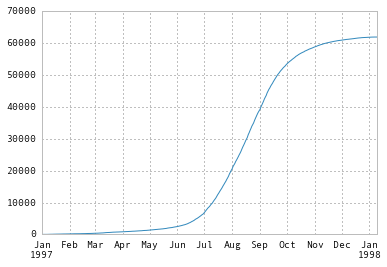

In [14]:
cumulative_cases.plot()

## Age distribution of cases

Distribution of cases by age, confirmed in blue and clinical in purple:

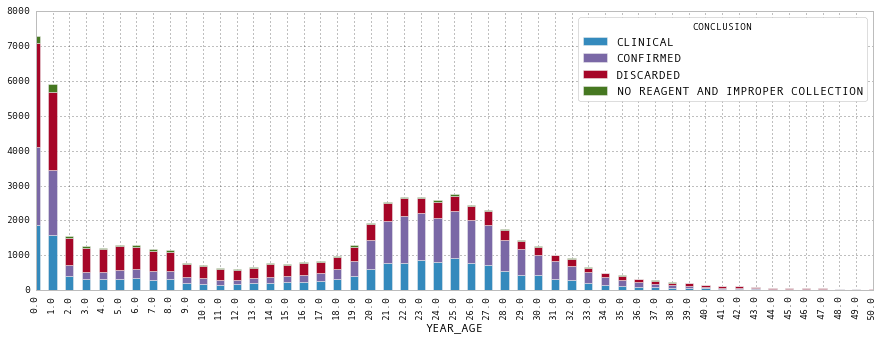

In [15]:
by_conclusion = measles_data.groupby(["YEAR_AGE", "CONCLUSION"])
counts_by_cause = by_conclusion.size().unstack().fillna(0)
ax = counts_by_cause.plot(kind='bar', stacked=True, xlim=(0,50), figsize=(15,5))

Estimating the probability of clinical confirmation of cases.

In [16]:
lab_subset = measles_data[(CONFIRMED | DISCARDED) & measles_data.YEAR_AGE.notnull() & measles_data.COUNTY.notnull()].copy()
lab_subset.loc[lab_subset.YEAR_AGE > 75, 'YEAR_AGE'] = 75
age = lab_subset.YEAR_AGE.astype(int).values
ages = lab_subset.YEAR_AGE.astype(int).unique()
counties = lab_subset.COUNTY.unique()
y = (lab_subset.CONCLUSION=='CONFIRMED').values
county_index = [np.where(counties==c)[0][0] for c in lab_subset.COUNTY]

In [17]:
lab_subset.DISTRICT.unique().size

157

In [18]:
counties = lab_subset.COUNTY.unique()
np.where(counties=='ALVARES FLORENCE')[0][0]

407

In [19]:
def confirmation_model():
    
    # County random effect
    sig_space = HalfCauchy("sig_space", 0, 25, value=10)
    tau_space = sig_space**-2
    beta = Normal("beta", mu=0, tau=tau_space, value=np.zeros(len(counties)))
    
    # Means by age
    mu = Normal("mu", mu=0, tau=0.0001, value=[0]*len(ages))
    sig = HalfCauchy('sig', 0, 25, value=1)
    var = sig**2
    cov = Uniform('cov', -1000, 1000, value=0)
    
    @deterministic
    def Sigma(var=var, cov=cov):
        # Variance-covariance matrix with first-order correlation
        I = np.eye(len(ages))*var
        E = np.diag(np.ones(len(ages)-1), k=-1)*cov
        return I + E + E.T
        
    theta = MvNormalCov("theta", mu=mu, C=Sigma, value=[0]*len(ages))
    p_age = Lambda('p_age', lambda t=theta: invlogit(t))

    @deterministic
    def p(theta=theta, beta=beta):
        # Probability of confirmation as a function of age and county
        return invlogit(theta[age] + beta[county_index])
    
    # Likelihood
    lab_confirmed = Bernoulli('lab_confirmed', p=p, value=y, observed=True)
    
    return locals()

In [20]:
from pymc import AdaptiveMetropolis

M = MCMC(confirmation_model())
M.use_step_method(AdaptiveMetropolis, M.beta)
M.sample(10000, 5000)

 [-----------------100%-----------------] 10000 of 10000 complete in 170.1 sec

/Users/fonnescj/GitHub/pymc2/pymc/StepMethods.py:1273: UserWarning: 
Covariance was not positive definite and proposal_sd cannot be computed by 
Cholesky decomposition. The next jumps will be based on the last 
valid covariance matrix. This situation may have arisen because no 
jumps were accepted during the last `interval`. One solution is to 
increase the interval, or specify an initial covariance matrix with 
a smaller variance. For this simulation, each time a similar error 
occurs, proposal_sd will be reduced by a factor .9 to reduce the 
jumps and increase the likelihood of accepted jumps.
  warnings.warn(adjustmentwarning)


Here are age-specific estimates of a clinically confirmed case coming back from the lab as measles positive, using the correlated random effects model above.

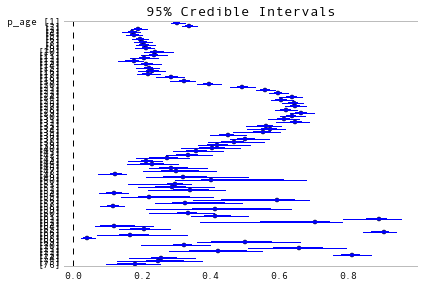

In [21]:
from pymc import Matplot

Matplot.summary_plot([M.p_age], rhat=False)

Age-specific means

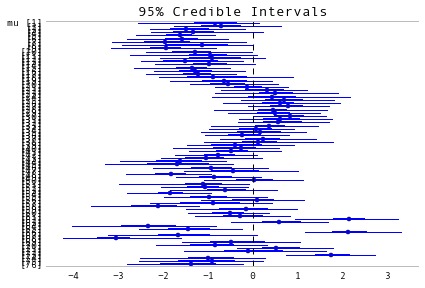

In [22]:
Matplot.summary_plot([M.mu], rhat=False)

## Estimation of Effective Reproductive Ratio in Sao Paulo

The effective reproducive ratio is the product of the transmission parameter, the size of the susceptible population, and the duration of infectiousness.

$$R_e = \beta S d$$

Latent (exposed) period: 6-9 days  
Infective period: 6-7 days

Since the disease runs its course over approximately 2 weeks, we can aggregate data by 2-week intervals, allowing us to set $d=1$.

In [23]:
city_only = False

if city_only:
    # Subset of cases in SP county
    sp_measles = measles_data[measles_data.COUNTY=='SAO PAULO']
else:
    sp_measles = measles_data.copy()

# Drop entries with missing onset dates
sp_measles = sp_measles[sp_measles.ONSET.notnull()]

Cumulative cases by district

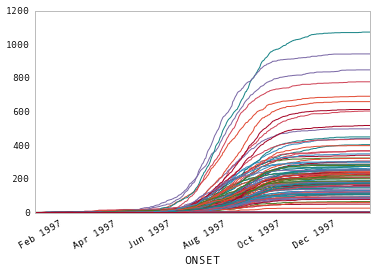

In [24]:
measles_onset_dist = sp_measles.groupby(['DISTRICT','ONSET']).size().unstack(level=0).fillna(0)
measles_onset_dist.cumsum().plot(legend=False, grid=False)

Age distribution of cases

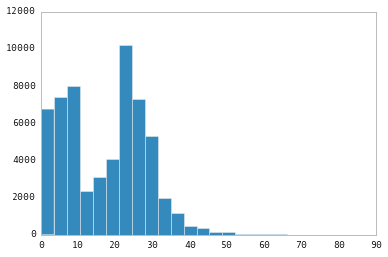

In [25]:
sp_measles.AGE.hist(grid=False, bins=25)

Monthly age distribution of cases (normalized)

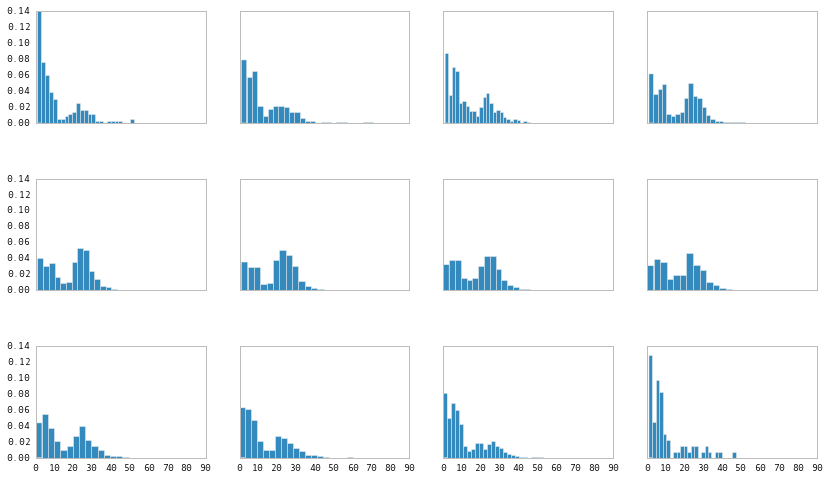

In [26]:
months = pd.date_range(start=sp_measles.ONSET.min(), periods=13, freq='M')

fig, axes = plt.subplots(3, 4, figsize=(14,8), sharex=True, sharey=True)

for i,ax in enumerate(axes.ravel()):
    #sp_measles[(sp_measles.ONSET<months[i+1])].AGE.hist(ax=ax, grid=False, bins=25, normed=True, alpha=0.4)
    sp_measles[(months[i]<=sp_measles.ONSET) & (sp_measles.ONSET<months[i+1])].AGE.hist(ax=ax, grid=False, 
                                                                                        bins=25, normed=True)

Cases by 2-week intervals

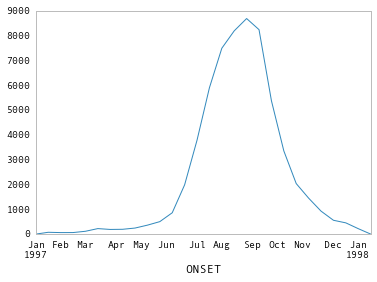

In [27]:
sp_cases_2w = sp_measles.groupby('ONSET').size().fillna(0).resample('2W', how='sum')
sp_cases_2w.plot(grid=False)

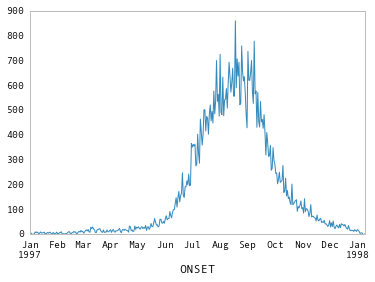

In [28]:
sp_cases = sp_measles.groupby('ONSET').size().resample('1D', how='sum').fillna(0)
sp_cases.plot(grid=False)

In [29]:
sp_pop.head()

,0 a 4 anos,5 a 9 anos,10 a 14 anos,15 a 19 anos,20 a 24 anos,25 a 29 anos,30 a 34 anos,35 a 39 anos,40 a 44 anos,45 a 49 anos,50 a 54 anos,55 a 59 anos,60 a 64 anos,65 a 69 anos,70 a 74 anos,75 anos e +,Total
AGUA RASA,5411,5750,6450,7122,7621,7340,6999,6984,6346,5608,4987,4212,4152,3595,2937,3637,89151
ALTO DE PINHEIROS,2070,2369,2953,3661,4612,4190,3539,3633,3448,3289,3040,2533,2298,1732,1305,1823,46495
ANHANGUERA,3068,3006,2755,2431,2426,2636,2695,2308,1653,1107,753,509,352,217,162,171,26249
ARICANDUVA,7732,7730,8373,8956,9182,8531,7813,7365,6551,5554,4887,3858,3320,2449,1611,1723,95635
ARTUR ALVIM,9031,9078,10000,11058,11387,10347,9125,8658,7830,7055,5919,4612,3756,2633,1727,1724,113940


Extract population in Sao Paulo districts

In [29]:
sp_districts = sp_measles.DISTRICT.unique()
N = sp_pop[sp_pop.index.isin(sp_districts)].Total.sum()
N

9757279

This model assumes:

- the population is closed over the duration of the outbreak
- the recovery time is fixed to 14 days
- all infections are detected by monitoring
- suscepibles at the start of the outbreak are represented by the sum of all cases

In [30]:
total_cases = sp_cases_2w.values.sum()

In [31]:
S = np.r_[total_cases, total_cases - np.cumsum(sp_cases_2w.values)].astype(int)[:-1]
S

array([61899, 61887, 61802, 61729, 61655, 61529, 61295, 61095, 60889,
       60633, 60260, 59745, 58873, 56874, 53076, 47163, 39656, 31448,
       22744, 14488,  9097,  5731,  3682,  2220,  1281,   711,   246,    14])

In [32]:
# Time steps
T = sp_cases_2w.size
# Cases
I = sp_cases_2w.values

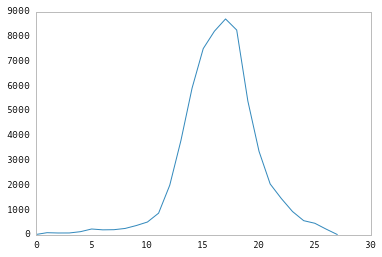

In [33]:
plt.plot(I)

In [31]:
def SIR(N_obs=N):
    
    scale_factor = Exponential('scale_factor', 1, value=1)
    
    N = Lambda('N', lambda s=scale_factor: N_obs*s)

    # Reproductive number
    R0 = Normal('R0', 15, 5, value=12)
    
    # Force of infection
    lam = Lambda('lam', lambda beta=R0, N=N: beta*I[:-1]/N)
    
    # 2-week infection probabilities
    p = Lambda('p', lambda lam=lam: 1 - np.exp(-lam))
    
    # Effective reproduction number
    Rt = Lambda('Rt', lambda R0=R0, N=N: R0 * S[:-1] / N)
    
    # Negative binomial clumping parameter
    alpha = Exponential('alpha', 1, value=1)
    
    # Expected number of cases
    theta = Lambda('theta', lambda p=p: p*S[:-1])
    
    # Negative binomial likelihood for observed cases
    new_cases = NegativeBinomial('new_cases', theta, alpha, value=I[1:], observed=True)
    new_cases_pred = NegativeBinomial('new_cases_pred', theta, alpha, value=I[1:])
    
    return(locals())

In [32]:
M_SIR = MCMC(SIR())

In [33]:
M_SIR.sample(50000, 40000)

 [-----------------100%-----------------] 50000 of 50000 complete in 20.4 sec

Predicted cases under the model

Plotting R0


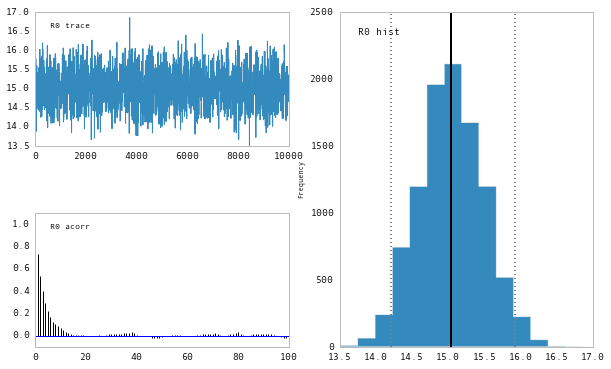

In [34]:
Matplot.plot(M_SIR.R0)

Plotting scale_factor


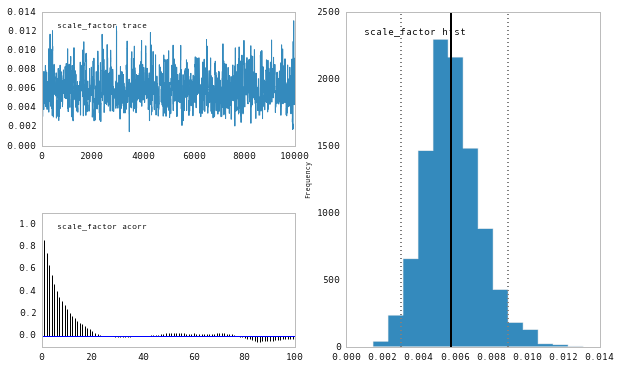

In [35]:
Matplot.plot(M_SIR.scale_factor)

Plotting N


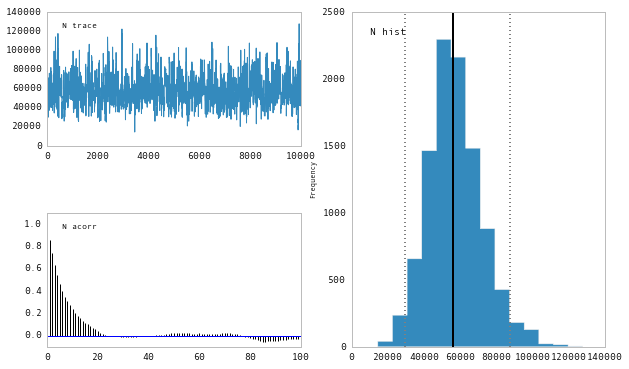

In [36]:
Matplot.plot(M_SIR.N)

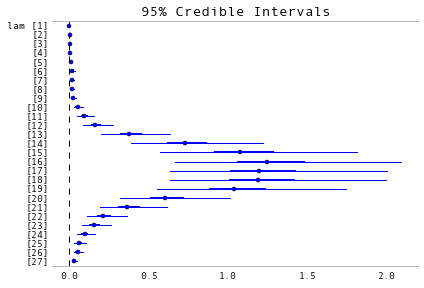

In [37]:
Matplot.summary_plot([M_SIR.lam], rhat=False)

Effective reproductive number

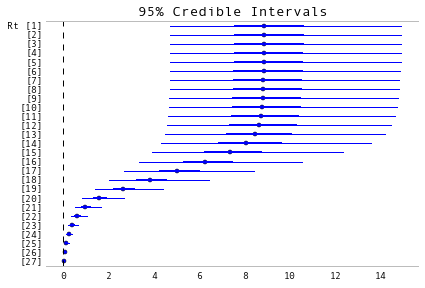

In [38]:
Matplot.summary_plot([M_SIR.Rt], rhat=False)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


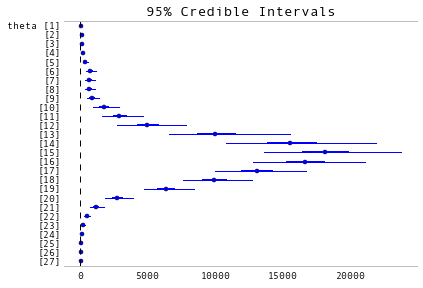

In [39]:
Matplot.summary_plot(M_SIR.theta)

In [40]:
def SIR2():
    
    alpha = Exponential('alpha', 1, value=1)
    
    # Reproductive number
    beta = Normal('beta', 15, 5, value=12)
    
    # Force of infection
    lam = Lambda('lam', lambda beta=beta, a=alpha: beta*I[:-1]**a)
    
    # Negative binomial likelihood for observed cases
    new_cases = NegativeBinomial('new_cases', lam, I[:-1], value=I[1:], observed=True)
    new_cases_pred = NegativeBinomial('new_cases_pred', lam, I[:-1], value=I[1:])
    
    return(locals())

In [48]:
from pymc import Slicer

M2 = MCMC(SIR2())
M2.use_step_method(Slicer, M2.beta)
M2.use_step_method(Slicer, M2.alpha)

In [49]:
M2.sample(100000, 90000)

 [-----------------100%-----------------] 100000 of 100000 complete in 66.9 sec

Plotting alpha


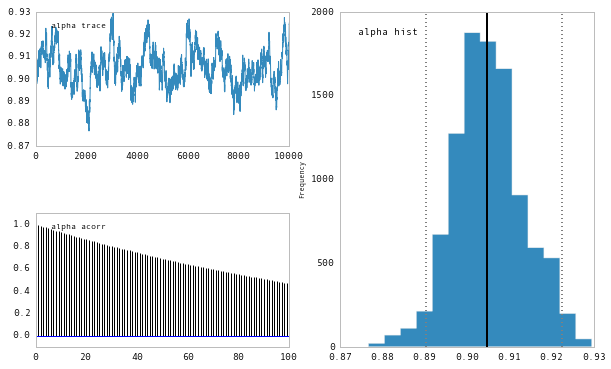

In [50]:
Matplot.plot(M2.alpha)

Plotting beta


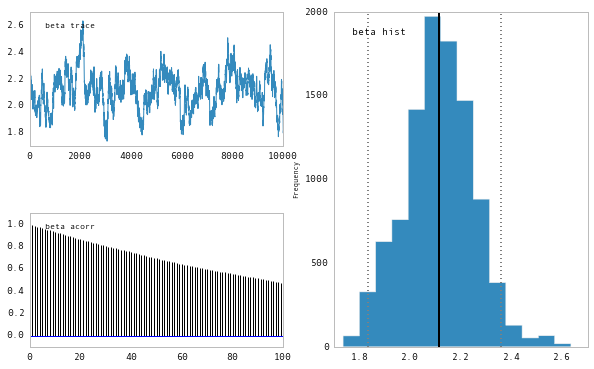

In [51]:
Matplot.plot(M2.beta)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


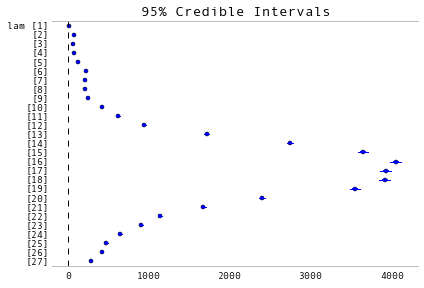

In [46]:
Matplot.summary_plot(M2.lam)

## SIR Model with Confirmation Sub-model

Create dummy variables corresponding to age groups in census data

In [44]:
age_classes = [0,5,10,15,20,25,30,35,40,45,50,55,60,66,70,75,100]
sp_measles['AGE_GROUP'] = pd.cut(sp_measles.AGE, age_classes, right=False)

2-week cases by age group

In [45]:
sp_cases_2w_age = sp_measles.groupby(['ONSET', 'AGE_GROUP']).size().unstack().fillna(0).resample('2W', how='sum')

Turn individual ages into age classes, and retrieve age class index

In [46]:
age_group = pd.cut(age, age_classes, right=False)
age_index = np.array([age_group.levels.tolist().index(i) for i in age_group])

In [47]:
# Order columns by age
index_order = np.argsort(map(lambda x: int(x[1:x.find(',')]), sp_cases_2w_age.columns))
sp_cases_2w_age.columns[index_order]
sp_cases_2w_age = sp_cases_2w_age.reindex_axis(sp_cases_2w_age.columns[index_order], 1)
sp_cases_2w_age

AGE_GROUP,"[0, 5)","[5, 10)","[10, 15)","[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 66)","[66, 70)","[70, 75)","[75, 100)"
ONSET,,,,,,,,,,,,,,,,
1997-01-05,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1997-01-19,5,4,2,0,0,3,0,0,0,0,0,0,0,0,0,0
1997-02-02,2,7,0,0,1,3,0,0,0,0,0,0,0,0,0,0
1997-02-16,5,5,0,0,4,2,0,0,0,0,0,0,0,0,0,0
1997-03-02,7,12,4,4,4,2,1,0,0,0,1,0,0,0,1,0
1997-03-16,20,17,6,9,10,11,4,0,0,1,0,0,0,0,0,0
1997-03-30,15,24,7,7,9,7,1,0,0,0,1,0,0,0,0,0
1997-04-13,16,23,5,4,11,7,2,2,1,0,0,0,0,0,0,0
1997-04-27,18,18,10,7,20,10,7,1,1,0,0,0,0,0,0,0


In [48]:
I_obs = sp_cases_2w_age
I_obs.to_csv('I_obs.csv')

In [49]:
pd.read_csv('I_obs.csv', index_col=0)

,"[0, 5)","[5, 10)","[10, 15)","[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 45)","[45, 50)","[50, 55)","[55, 60)","[60, 66)","[66, 70)","[70, 75)","[75, 100)"
ONSET,,,,,,,,,,,,,,,,
1997-01-05,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1997-01-19,5,4,2,0,0,3,0,0,0,0,0,0,0,0,0,0
1997-02-02,2,7,0,0,1,3,0,0,0,0,0,0,0,0,0,0
1997-02-16,5,5,0,0,4,2,0,0,0,0,0,0,0,0,0,0
1997-03-02,7,12,4,4,4,2,1,0,0,0,1,0,0,0,1,0
1997-03-16,20,17,6,9,10,11,4,0,0,1,0,0,0,0,0,0
1997-03-30,15,24,7,7,9,7,1,0,0,0,1,0,0,0,0,0
1997-04-13,16,23,5,4,11,7,2,2,1,0,0,0,0,0,0,0
1997-04-27,18,18,10,7,20,10,7,1,1,0,0,0,0,0,0,0


In [50]:
I_obs = sp_cases_2w_age.values.astype(int)

In [51]:
I_obs.shape

(28, 16)

In [74]:
I_obs = sp_cases_2w_age.values.astype(int)

def SIR_confirmation(N_obs=N):
    
    '''
    Confirmation submodel
    '''
    
    age_classes = np.unique(age_index)
    
    # County random effect
    sig_space = HalfCauchy("sig_space", 0, 25, value=10)
    tau_space = sig_space**-2
    beta_county = Normal("beta_county", mu=0, tau=tau_space, value=np.zeros(len(counties)))
    
    # Means by age
    mu = Normal("mu", mu=0, tau=0.0001, value=[0]*len(age_classes))
    sig = HalfCauchy('sig', 0, 25, value=1)
    var = sig**2
    cov = Uniform('cov', -1000, 1000, value=0)
    
    @deterministic
    def Sigma(var=var, cov=cov):
        # Variance-covariance matrix with first-order correlation
        I = np.eye(len(age_classes))*var
        E = np.diag(np.ones(len(age_classes)-1), k=-1)*cov
        return I + E + E.T
        
    beta_age = MvNormalCov("beta_age", mu=mu, C=Sigma, value=[1]*len(age_classes))
    p_age = Lambda('p_age', lambda t=beta_age: invlogit(t))

    @deterministic
    def p_confirm(theta=beta_age, beta=beta_county):
        # Probability of confirmation as a function of age and county
        return invlogit(theta[age_index] + beta[county_index])
    
    # Likelihood
    lab_confirmed = Bernoulli('lab_confirmed', p=p_confirm, value=y, observed=True)
    
    '''
    SIR Model
    '''
    
    #scale_factor = Exponential('scale_factor', 1, value=1)
    
    #N = Lambda('N', lambda s=scale_factor: N_obs*s)
    N = N_obs

    # Infection rate (reproductive number, in this case, since gamma=1)
    beta = Normal('beta', 15, 5, value=12)
    
    # Confirmed cases
    @stochastic
    def I(value=I_obs.T*0.9, n=I_obs.T, p=p_age):
        return np.sum([binomial_like(value[i], n[i], p[i]) for i in range(len(p))])
    
    I_total = Lambda('I_total', lambda I=I: I.sum(0))
    S_total = Lambda('S_total', lambda I=I_total: I.sum() - I.cumsum())
    
    # Force of infection
    lam = Lambda('lam', lambda beta=beta, N=N, I=I_total: beta*I/N)
    
    # 2-week infection probabilities
    p = Lambda('p', lambda lam=lam: 1 - np.exp(-lam))
    
    # Effective reproduction number
    Rt = Lambda('Rt', lambda beta=beta, N=N, S=S_total: beta * S / N)
    
    # Negative binomial clumping parameter
    alpha = Exponential('alpha', 1, value=1)
    
    # Expected number of cases
    theta = Lambda('theta', lambda p=p, S=S_total: p*S)
    
    # Negative binomial likelihood for observed cases
    @potential
    def new_cases(theta=theta, alpha=alpha, I=I_total): 
        return np.sum([negative_binomial_like(i, t, alpha) for t,i in zip(theta, I)])
    
    return locals()

In [75]:
M = MCMC(SIR_confirmation())

In [76]:
from pymc import graph
graph.dag(M)

In [77]:
M.sample(20000, 10000)

 [-----------------100%-----------------] 20000 of 20000 complete in 223.7 sec

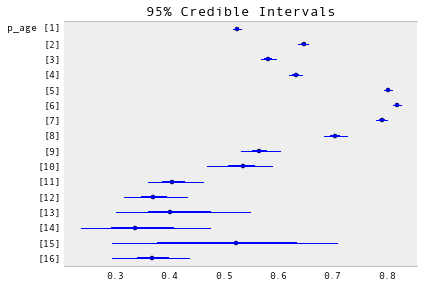

In [78]:
Matplot.summary_plot([M.p_age], rhat=False)

In [84]:
I_obs.sum(1)

array([   1,   14,   13,   16,   36,   78,   71,   71,   92,  194,  326,
        592, 1332, 2513, 3731, 4364, 4215, 4188, 3627, 2169, 1292,  771,
        557,  349,  221,  181,  105,    4])

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


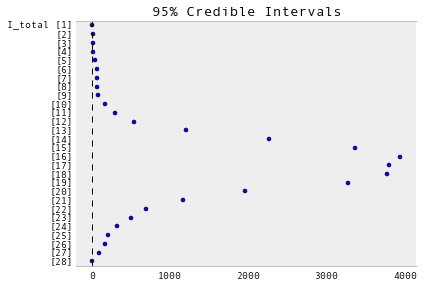

In [79]:
Matplot.summary_plot(M.I_total)

Plotting beta


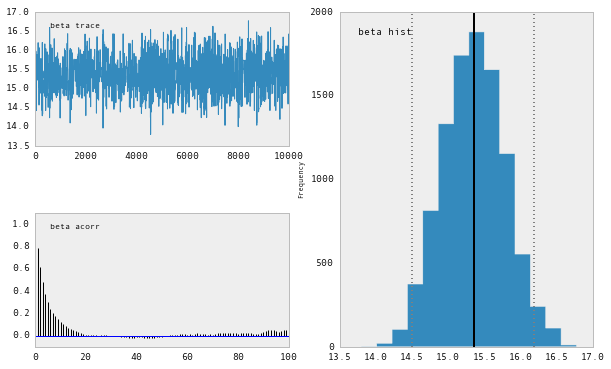

In [80]:
Matplot.plot(M.beta)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


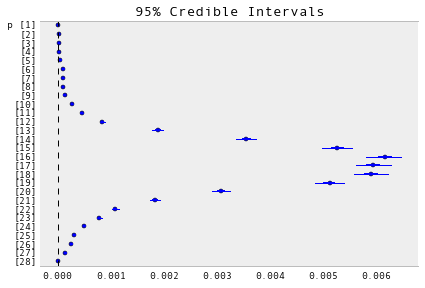

In [85]:
Matplot.summary_plot(M.p)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


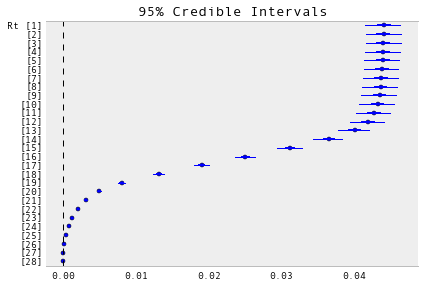

In [81]:
Matplot.summary_plot(M.Rt)

## Mapping

In [7]:
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import LineCollection, PolyCollection

First, a map of the cases in each county within Sao Paulo state.

In [31]:
# Set up basemap
lllat=-26
urlat=-19
lllon=-53
urlon=-43
SP_region = Basemap(ax=None, projection='merc', lon_0=(urlon + lllon) / 2, lat_0=(urlat + lllat) / 2,
        llcrnrlat=lllat, urcrnrlat=urlat, llcrnrlon=lllon, urcrnrlon=urlon, resolution='i',
    epsg='4326')

Compile case counts by county:

In [53]:
foo = u'S\xc3O JO\xc3O DO JAGUARIBE'
#foo.encode('trans')
trans.trans(foo)

'SAO JOAO DO JAGUARIBE'

In [23]:
import geopandas as gpd

SP_state = gpd.GeoDataFrame.from_file('Sao Paulo/Shape/Estado SP_region.shp').to_crs({'proj': 'longlat', 
                                                                                      'ellps': 'WGS84', 
                                                                                      'datum': 'WGS84'})

In [24]:
SP_state.MUNICIPIO.apply(lambda x: trans.trans(x).upper())

0                    ADOLFO
1                     AGUAI
2            AGUAS DA PRATA
3          AGUAS DE LINDOIA
4    AGUAS DE SANTA BARBARA
5        AGUAS DE SAO PEDRO
6                  ALAMBARI
7         ALFREDO MARCONDES
8                    ALTAIR
9               ALTINOPOLIS
...
634     RIBEIRAO DOS INDIOS
635         SANTO ANASTACIO
636                 TRABIJU
637         GENERAL SALGADO
638           NOVA CASTILHO
639                  FERNAO
640                   GALIA
641          GAVIAO PEIXOTO
642              ARARAQUARA
643    BOA ESPERANCA DO SUL
644              ADAMANTINA
Name: MUNICIPIO, Length: 645, dtype: object

In [25]:
# Get rid of latin characters
municipio = SP_state.MUNICIPIO.apply(lambda x: trans.trans(x).upper())
# municipio = [_['MUNICIPIO'].decode('latin1').encode('trans').upper() for _ in SP_region.region_info]
# Initialize a dictionary of case counts by county
state_cases = {x : 0 for x in municipio}
# Remap names
name_map = {'MOGI-MIRIM':'MOJI-MIRIM', 
    'MOGI DAS CRUZES':'MOJI DAS CRUZES', 
    'SANTA CRUZ DAS PALMAS':'SANTA CRUZ DAS PALMEIRAS',
    'SANTANA DO PARNAIBA':'SANTANA DE PARNAIBA',
    'PRESIDENTE VENCESLA':'PRESIDENTE VENCESLAU',
    'CAMPO LIMPO PAULIST':'CAMPO LIMPO PAULISTA',
    'SANTA CRUZ RIO PARD':'SANTA CRUZ DO RIO PARDO',
    'SAO MANOEL':'SAO MANUEL'}
invalid = {'PORTO ALEGRE'}

# Obtain counts by county
for county in measles_data.COUNTY:
    try:
        state_cases[county] += 1
    except KeyError:
        try:
            state_cases[name_map[county]] += 1
        except KeyError:
            if county in invalid:
                continue

Map cases, coloring the city of Sao Paulo black, since it has so many cases

In [43]:
state_cases_df = pd.DataFrame({'cases':pd.Series(state_cases).apply(lambda x: np.log(x+1))})

In [44]:
SP_state['SEM_ACENTO'] = SP_state['SEM_ACENTO'].apply(lambda x: x.upper())

In [45]:
SP_state = pd.merge(SP_state, state_cases_df, left_on='SEM_ACENTO', right_index=True)

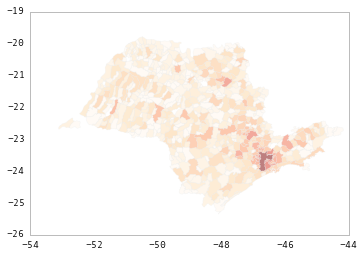

In [46]:
SP_state.plot(column='cases', k=5, colormap='OrRd', linewidth=0)

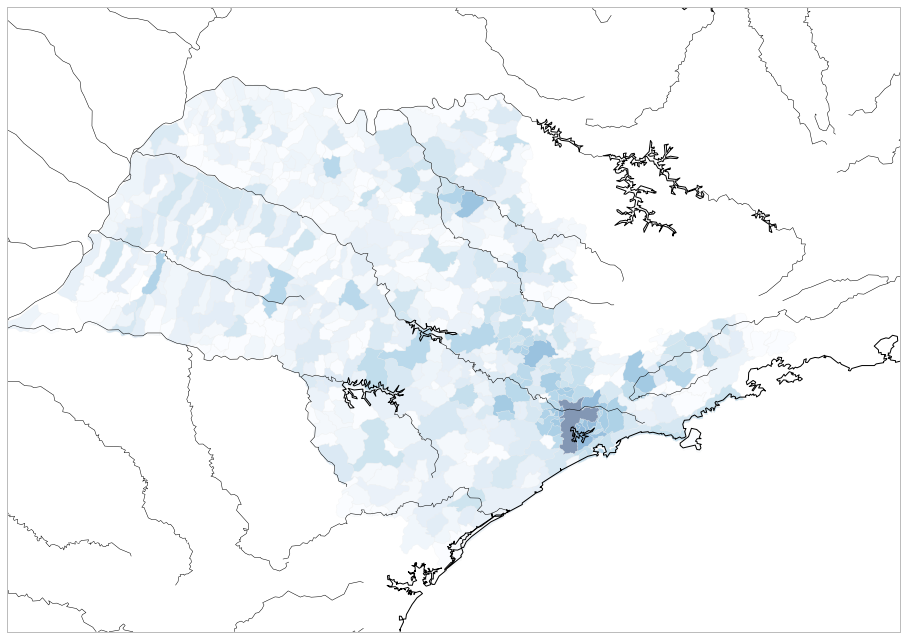

In [47]:
from matplotlib.pyplot import cm, colorbar
from mpl_toolkits.basemap import Polygon, PolyCollection

fig = plt.figure(figsize=(16,12))
ax = plt.gca()
SP_region.drawcoastlines()
SP_region.drawrivers()
SP_state.plot(column='cases', colormap=cm.Blues, k=15, linewidth=0, axes=ax)
# z = [state_cases[i]*(i!='SAO PAULO') for i in municipio]
# coll = PolyCollection(SP_region.region, array=np.array(z), cmap=cm.Blues, edgecolors='none')
# ax.add_collection(coll)
# colorbar(coll, ax=ax, shrink=0.7)

# sp_poly = Polygon(SP_region.region[municipio.index('SAO PAULO')], facecolor='black')
# ax.add_patch(sp_poly)

## Cases by Sao Paulo district

In [75]:
if city_only:
    districts = measles_data.DISTRICT[measles_data.COUNTY=='SAO PAULO'].unique().astype(str)
else:
    districts = measles_data.DISTRICT.unique().astype(str)
districts.sort()

In [85]:
from collections import defaultdict

In [115]:
city_cases = dict(sp_measles.DISTRICT.fillna(sp_measles.COUNTY).value_counts())

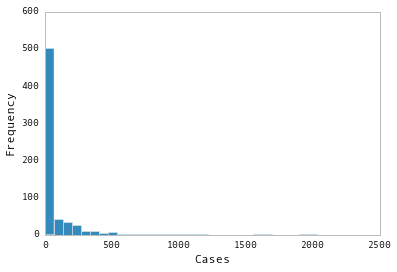

In [126]:
casevals = np.sort(list(city_cases.values()))
# Remove Sao Paulo
plt.hist(casevals[:-1], bins=30)
plt.xlabel('Cases')
plt.ylabel('Frequency')

Turn the stacked population series into a data frame, and add an empty `cases` column:

In [ ]:
sp_combined = pd.DataFrame({'population':sp_pop_age, 'cases':0})

Now we can populate the cases for district x age class

In [128]:
# Lookup table for invalid districts
dist_map = {'ALTO PINHEIROS': 'ALTO DE PINHEIROS',
    'JARAGUQ': 'JARAGUA',
    'VILAILA MEDEIROS': 'VILA MEDEIROS',
    'VILAILA MARIANA': 'VILA MARIANA',
    'VILAILA ANDRADE': 'VILA ANDRADE',
    'VILAILA SONIA': 'VILA SONIA',
    'VILAILA CURUCA': 'VILA CURUCA',
    'VILAILA FORMOSA': 'VILA FORMOSA',
    'VILAL FORMOSA': 'VILA FORMOSA',
    'VILAILA MARIA': 'VILA MARIA',
    'VILAILA MATILDE': 'VILA MATILDE',
    'JA\xe2ANA': 'JACANA',
    'CONSOLA\xe2AO': 'CONSOLACAO', 
    'VILA CACHOEIRINHA': 'CACHOEIRINHA',
    'STA CECILIA': 'SANTA CECILIA',
    'VILA DALVILAA': 'VILA MATILDE',
    'VILA.LEOPOLDINA': 'VILA LEOPOLDINA',
    'LAGEADO': 'LAJEADO',
    'CAPELA DO SOCOR': 'SOCORRO',
    'VILA. PRUDENTE': 'VILA PRUDENTE',
    'GUAIANAZES': 'GUAIANASES',
    'VILA. ANDRADE': 'VILA ANDRADE',
    'CPELA SOCORRO': 'SOCORRO',
    'VILA. FORMOSA': 'VILA FORMOSA',
    'PDREIRA': 'PEDREIRA',
    'PINHIROS': 'PINHEIROS',
    'JAQUARE': 'JAGUARE',
    'SAO LUIZ': 'JARDIM SAO LUIS',
    'LUZ': 'JARDIM SAO LUIS',
    'PQ.DO CARMO': 'PARQUE DO CARMO',
    'S LUIZ': 'JARDIM SAO LUIS',
    'VILA.JAGUARA': 'JAGUARA',
    'INTERLAGOS': 'SOCORRO',
    'ERMELINO MATARAZO': 'ERMELINO MATARAZZO',
    'S LUCAS': 'SAO LUCAS',
    'JARAQUA': 'JARAGUA',
    'REPUPLICA': 'REPUBLICA',
    'VILA.CARRAO': 'CARRAO',
    'JAD SAO LUIZ': 'JARDIM SAO LUIS',
    'AMERICANOPOLIS': 'JABAQUARA',
    'STO AMARO': 'SANTO AMARO',
    'REUBLICA': 'REPUBLICA',
    'S MATHEUS': 'SAO MATEUS',
    'C REDONDO': 'CAPAO REDONDO',
    'CAPELA SOCORRO': 'SOCORRO',
    'S.MATEUS': 'SAO MATEUS',
    'SACOMAN': 'SACOMA',
    'SAO LUIS': 'JARDIM SAO LUIS',
    'TAIPAS': 'JARAGUA',
    'IQUATEMI': 'IGUATEMI',
    'JARDIM SAO LUIZ': 'JARDIM SAO LUIS',
}
# These are not districts at all
not_district = ['SUMARE', 'SAO PAULO', 'IGN', 'IGNORADO', 'CIDADE TIRADENT', 'CERQUEIRA CESAR']

# Lookup list for age classes
age_index = ['0 a 4 anos']*5 + \
['5 a 9 anos']*5 + \
['10 a 14 anos']*5 + \
['15 a 19 anos']*5 + \
['20 a 24 anos']*5 + \
['25 a 29 anos']*5 + \
['30 a 34 anos']*5 + \
['35 a 39 anos']*5 + \
['40 a 44 anos']*5 + \
['45 a 49 anos']*5 + \
['50 a 54 anos']*5 + \
['55 a 59 anos']*5 + \
['60 a 64 anos']*5 + \
['65 a 69 anos']*5 + \
['70 a 74 anos']*5 + \
['75 anos e +']*25

for idx in measles_data.index[measles_data.COUNTY=='SAO PAULO']:

    # Extract district name
    dist = measles_data.ix[idx]['DISTRICT']
    
    if dist in not_district: continue
    if dist is np.nan: continue
    
    # Extract age of case
    try:
        age = int(measles_data.ix[idx]['YEAR_AGE'])
    except ValueError:
        # Missing age
        try:
            sp_combined.ix[(dist, 'Total')] += 1
        except KeyError:
            sp_combined.ix[(dist_map[dist], 'Total')] += 1
        continue
    
    # Increment case count for district x age class
    try:
        sp_combined.ix[(dist, age_index[age])] += 1
        sp_combined.ix[(dist, 'Total')] += 1
    except KeyError:
        sp_combined.ix[(dist_map[dist], age_index[age])] += 1
        sp_combined.ix[(dist_map[dist], 'Total')] += 1


Here is what the clean dataset for cases within districts looks like:

In [129]:
sp_combined['proportion'] = sp_combined.cases/sp_combined.population

In [130]:
sp_combined.head(25)

cases  population  proportion
AGUA RASA         0 a 4 anos       32        5443    0.005879
                  5 a 9 anos       22        5772    0.003812
                  10 a 14 anos      9        6459    0.001393
                  15 a 19 anos     12        7134    0.001682
                  20 a 24 anos     34        7655    0.004442
                  25 a 29 anos     31        7371    0.004206
                  30 a 34 anos     11        7010    0.001569
                  35 a 39 anos      6        6990    0.000858
                  40 a 44 anos      2        6348    0.000315
                  45 a 49 anos      0        5608    0.000000
                  50 a 54 anos      0        4987    0.000000
                  55 a 59 anos      0        4212    0.000000
                  60 a 64 anos      0        4152    0.000000
                  65 a 69 anos      0        3595    0.000000
                  70 a 74 anos      0        2937    0.000000
                  75 anos e +       0        3637    0.000000
                  Total           162       89313    0.001814
ALTO DE PINHEIROS 0 a 4 anos        7        2077    0.003370
                  5 a 9 anos       10        2379    0.004203
                  10 a 14 anos      5        2958    0.001690
                  15 a 19 anos     13        3674    0.003538
                  20 a 24 anos     17        4629    0.003672
                  25 a 29 anos     13        4203    0.003093
                  30 a 34 anos      8        3547    0.002255
                  35 a 39 anos      5        3638    0.001374

In [131]:
# Write to CSV file
sp_combined.to_csv("SP_district_cases.csv")

## Map of Sao Paulo District Cases

In [162]:
lllat=-24
urlat=-23.3
lllon=-47
urlon=-46.3

SP_dist = Basemap(ax=None, projection='merc', lon_0=(urlon + lllon) / 2, lat_0=(urlat + lllat) / 2,
        llcrnrlat=lllat, urcrnrlat=urlat, llcrnrlon=lllon, urcrnrlon=urlon, resolution='f')

In [163]:
SP_info = SP_dist.readshapefile('Sao Paulo/Brazil_full/BRA_adm3','brazil', drawbounds=False)
print(SP_info)

(10193, 5, [-73.98970699999995, -33.74708099999998, 0.0, 0.0], [-32.389582999999845, 5.264877999999953, 0.0, 0.0])


In [164]:
map_districts = [_['NAME_3'].decode('latin1').encode('trans').upper() for _ in SP_dist.brazil_info]

In [165]:
SP_dist.brazil_info[100]

{'ENGTYPE_3': 'District',
 'HASC_3': '                         ',
 'ID_0': 32,
 'ID_1': 431,
 'ID_2': 3648,
 'ID_3': 4054,
 'ISO': 'BRA',
 'NAME_0': 'Brazil',
 'NAME_1': 'Alagoas',
 'NAME_2': 'Col\xf4nia Leopoldina',
 'NAME_3': 'Col\xf4nia Leopoldina',
 'NL_NAME_3': '                                                                           ',
 'REMARKS_3': '                                                  ',
 'RINGNUM': 1,
 'SHAPENUM': 96,
 'Shape_Area': '2.36783278470e-002',
 'Shape_Leng': '7.81454479178e-001',
 'TYPE_3': 'Distrito',
 'VALIDFR_3': 'Unknown',
 'VALIDTO_3': 'Present',
 'VARNAME_3': '                                                                                                    '}

<matplotlib.colorbar.Colorbar instance at 0x1a61d97a0>

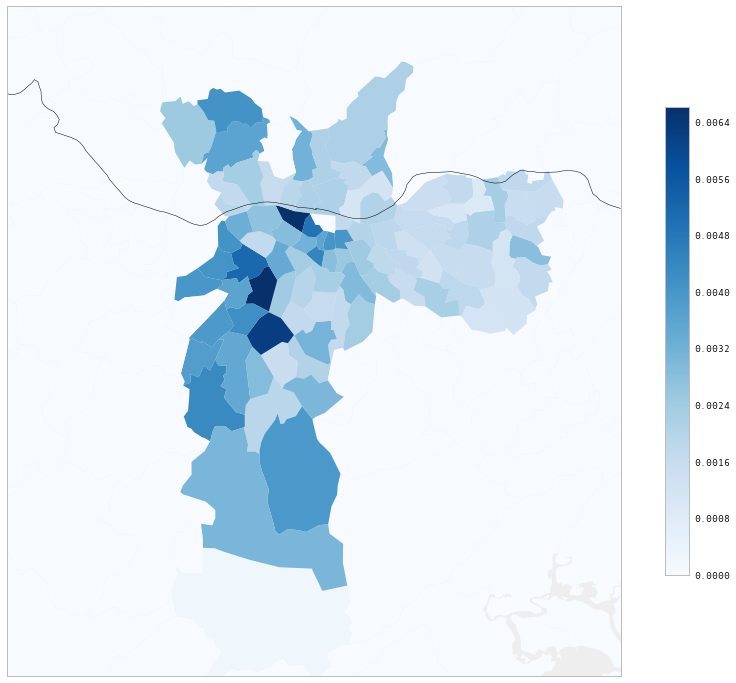

In [166]:
map_fig = plt.figure(figsize=(16,12))
map_ax = plt.gca()
#SP_dist.drawcoastlines()
SP_dist.drawrivers()

p = [0]*len(map_districts)
for i,d in enumerate(map_districts):
    try:
        p[i] = sp_combined.ix[(d, 'Total')]['proportion']
    except KeyError:
        pass
dist_coll = PolyCollection(SP_dist.brazil, array=np.array(p), cmap=cm.Blues, edgecolors='none')
map_ax.add_collection(dist_coll)
colorbar(dist_coll, ax=map_ax, shrink=0.7)

## Spatial Model

In [167]:
from shapely.geometry import Point, mapping, shape, MultiPolygon
from fiona import collection
import fiona

shp = fiona.open("Sao Paulo/Brazil_full/BRA_adm3.shp")

In [170]:
N = sp_pop.Total

In [171]:
district_names = N.index.unique()

In [172]:
get_name = lambda x: unicode(x['properties']['NAME_3']).encode('trans').upper()
district_polygons = {get_name(pol): shape(pol['geometry']) for pol in shp 
                     if get_name(pol) in district_names}
# Number of matches between districts and polygons
len(district_polygons)

95

In [173]:
new_index = N.index.values
new_index[new_index=='BRASILANDIA'] = 'BRAZLANDIA'
N.index = new_index
N.shape

(97,)

Calculate distance matrix

In [174]:
distances = {p1: {p2: district_polygons[p1].distance(district_polygons[p2]) 
                    for p2 in district_polygons if p2 in N.index} for p1 in district_polygons if p1 in N.index}
distance_matrix = pd.DataFrame(distances)
distance_matrix.shape

(95, 95)

Summarize cases by district and time

In [175]:
measles_data.DISTRICT = measles_data.DISTRICT.replace({'BRASILANDIA': 'BRAZLANDIA'})

In [176]:
sp_measles_data = measles_data[measles_data.DISTRICT.isin(N.index)]

In [177]:
measles_groupby = sp_measles_data.groupby(['DISTRICT', 'ONSET']).size()
cases_by_district = measles_groupby.unstack(0).fillna(0).resample('2W', how='sum').fillna(0)
cases_by_district

DISTRICT,AGUA RASA,ANHANGUERA,ARICANDUVA,ARTUR ALVIM,BARRA FUNDA,BELA VISTA,BELEM,BOM RETIRO,BRAS,BRAZLANDIA,...,VILA FORMOSA,VILA GUILHERME,VILA JACUI,VILA LEOPOLDINA,VILA MARIA,VILA MARIANA,VILA MATILDE,VILA MEDEIROS,VILA PRUDENTE,VILA SONIA
ONSET,,,,,,,,,,,,,,,,,,,,,
1997-01-05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997-01-19,0,0,0,1,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1997-02-02,0,0,1,1,0,2,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1997-02-16,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1997-03-02,0,0,0,0,0,1,0,1,0,6,...,0,0,0,1,0,0,0,0,0,0
1997-03-16,0,0,0,0,1,0,0,2,0,6,...,1,0,0,0,0,2,1,0,0,0
1997-03-30,0,0,0,8,0,0,0,0,0,1,...,0,0,0,1,0,3,0,1,0,0
1997-04-13,0,0,0,8,0,0,0,0,0,2,...,0,0,0,1,2,5,1,0,1,2
1997-04-27,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [178]:
I = cases_by_district.T.values
I.shape

(93, 28)

In [179]:
total_cases = I.sum(1)
S = np.c_[total_cases, total_cases[:, np.newaxis] - I.cumsum(1)][:, :-1]
S.shape

(93, 28)

Filter out districts not represented in distance matrix.

In [180]:
N = N.reindex(cases_by_district.columns).dropna()
N.shape

(93,)

In [181]:
distance_matrix = distance_matrix.reindex_like(N).T.reindex_like(N)

In [192]:
from pymc import rlognormal

In [197]:
districts, times = I.shape

def SIR_spatial():
    
    # Compute effective population size, by weighting populations of neighboring districts
    scale_factor = Exponential('scale_factor', 1, value=1)
    #distance_weights = Lambda('distance_weights', lambda s=scale_factor: np.exp(-s*distance_matrix))
    
    #N_eff = Lambda('N_eff', lambda d=distance_weights: d.dot(N.values))
    N_eff = Lambda('N_eff', lambda s=scale_factor: N*s)
    assert N_eff.value.shape == (districts,)
    
    # Priors for R0 random effect
    mu_R0 = Normal('mu_R0', 15, 0.25, value=15)
    log_mu_R0 = Lambda('log_mu_R0', lambda m=mu_R0: np.log(m))
    sigma_R0 = Uniform('sigma_R0', 0, 10, value=4)
    tau_R0 = sigma_R0**-2
    
    # District R0 values
    R0 = Lognormal('R0', mu_R0, tau_R0, value=[15]*districts)
    
    # Infection rate
    beta = Lambda('beta', lambda R0=R0: R0*gamma)
    
    # Force of infection
    lam = Lambda('lam', lambda beta=beta, N=N_eff: beta[:, np.newaxis] * I / N[:, np.newaxis])
    
    # 2-week infection probabilities
    p = Lambda('p', lambda lam=lam: 1 - np.exp(-lam))
    
    # Effective reproduction number
    Rt = Lambda('Rt', lambda beta=beta, R0=R0: R0[:, np.newaxis] * S[:, :-1] / N[:, np.newaxis])
    
    # Negative binomial clumping parameter
    alpha = Exponential('alpha', 1, value=1)
    
    # Expected number of cases
    theta = Lambda('theta', lambda p=p: p*S)
    
    # Negative binomial likelihood for observed cases
    @observed
    def new_cases(value=I, theta=theta, alpha=alpha):
        # Need to filter out values that have no cases
        return np.sum([negative_binomial_like(x[t>0], t[t>0], alpha) for x,t in zip(value, theta)])
    
    return(locals())

In [198]:
M_spatial = MCMC(SIR_spatial())

In [199]:
M_spatial.sample(20000, 10000)

 [-----------------100%-----------------] 20000 of 20000 complete in 93.5 sec

Plotting sigma_R0


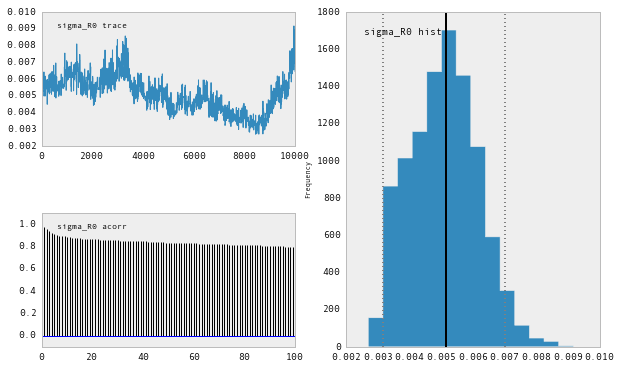

In [207]:
Matplot.plot(M_spatial.sigma_R0)

(array([  106.,   398.,  1162.,  1776.,  1501.,  1462.,  1391.,  1596.,
          517.,    91.]),
 array([ 14.88975172,  14.90224832,  14.91474492,  14.92724152,
         14.93973812,  14.95223472,  14.96473132,  14.97722792,
         14.98972451,  15.00222111,  15.01471771]),
 <a list of 10 Patch objects>)

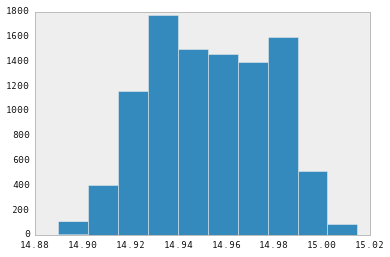

In [205]:
plt.hist(np.exp(M_spatial.mu_R0.trace()))

ERROR! Session/line number was not unique in database. History logging moved to new session 825
Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


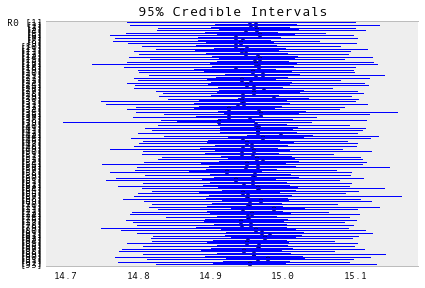

In [206]:
Matplot.summary_plot(M_spatial.R0)